In [1]:
import collections
import copy
import itertools
import json
import datetime
import random
import time


import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import tqdm

In [2]:
LANGUAGES = [
    "rust",
    "python",
    "javascript",
    "java",
    "ruby",
    "r",
    "c",
    "php",
]

In [5]:
def get_distance(neighbors: dict, start: str, end: str):
    """
    Ordinary BFS Graph search with distance calculation between start and end.
    Distance is returned as np.infty if nodes are in different components.
    """
    have_seen = set([start])
    todo = collections.deque([(start, 0)])
    while todo:
        act, dist = todo.popleft()
        for neighbor in neighbors[act]:
            if neighbor in have_seen:
                continue
            if neighbor == end:
                return dist + 1
            have_seen.add(neighbor)
            todo.append((neighbor, dist + 1))
    return np.infty


def iter_items(parser):
    for prefix, event, value in parser:
        if event == 'string':
            yield prefix, value


def load_libs(language):
    loot = {}
    date, imports = None, []
    with open(f"data/results/{language}/{language}_{language}_post_stats.json") as infile:
        for prefix, event, value in tqdm.tqdm(ijson.parse(infile)):
            if prefix == "item.date":
                date = value
            elif prefix == "item.imports.item":
                imports.append(value)
            elif event == "end_map":
                loot[date] = imports
                date, imports = None, []
    return loot


def get_dates_count_in_window(start_date_str: str, dates: list, window_days):
    start_date = datetime.datetime.strptime(start_date_str, "%Y-%m-%d")
    index = 0
    while (
        index < len(dates) and 
        datetime.datetime.strptime(dates[index], "%Y-%m-%d") < start_date + datetime.timedelta(days=window_days)
    ):
        index += 1
    return index


def get_valuable_libraries(language, window_days, hit_threshold ):
    with open(f"data/results/{language}/{language}_libs_first_dates.json") as handle:
        libs_first_dates = json.load(handle)
        
    with open(f"data/results/{language}/{language}_all_libs_dates.json") as handle:
        all_libs_dates = json.load(handle)

    valuable_libs = set([
        k for k, v in libs_first_dates.items() if
        get_dates_count_in_window(v['date'], all_libs_dates[k], window_days) >= hit_threshold
    ])
    return valuable_libs


def get_valuable_pairs(language, window_days, hit_threshold ):
    with open(f"data/results/{language}/{language}_pairs_first_dates.json") as handle:
        pairs_first_dates = json.load(handle)
        
    with open(f"data/results/{language}/{language}_all_pairs_dates.json") as handle:
        all_pairs_dates = json.load(handle)

    valuable_pairs = set([
        k for k, v in pairs_first_dates.items() if
        get_dates_count_in_window(v['date'], all_pairs_dates[k], window_days) >= hit_threshold
    ])
    return valuable_pairs


In [4]:
get_valuable_pairs('python', 365, 5)

{'symengine|sympy',
 '__future__|tensorflow_hub',
 'logging|rich',
 'selenium|urllib',
 'PIL|scrapy',
 'VideoCapture|sys',
 'polars|statsmodels',
 'multiprocessing|webdriver_manager',
 'RPi|time',
 'pandas|requests',
 'os|webbrowser',
 'PyQt5|pyaudio',
 'datetime|django',
 'convtools|csv',
 'json|jsonschema',
 'pandas|pytz',
 'math|torchmetrics',
 'heapq|statistics',
 'dash_table|pymongo',
 'IPython|traitlets',
 'myurllist|socbindtry',
 'quandl|sklearn',
 'matplotlib|pysal',
 'exchangelib|os',
 'csv|msilib',
 'gc|sklearn',
 'django|rest_framework_swagger',
 'Sprite1|pygame',
 'configparser|python_mysql_dbconfig',
 'collections|rest_framework',
 'os|shelve',
 'pytorch_lightning|time',
 'api|uuid',
 'concurrent|multiprocessing',
 'StringIO|requests',
 'colorcet|pandas',
 'config|flask_babel',
 'MySQLdb|numpy',
 'car_manager|player',
 'Projectile|player',
 'msedge|selenium',
 'openpyxl|unicodedata',
 'dask|glob',
 'hyperas|hyperopt',
 'contextily|matplotlib',
 'tortoise|typing',
 'sys|thr

In [23]:
"""
Populate the library graph in sequential order of the first appearance of the library pairs.
Calculate the distance of the newly introduced lib pair in the graph
(add the lib vertices if they had not been present).
Return the distances calculated for each pair. Save the JSON in file.
"""
for language in LANGUAGES:
    print(f">>{language}<<")
    
    with open(f"data/results/{language}/{language}_pairs_first_dates.json") as handle:
        pairs_first_dates = json.load(handle)

    neighbors = collections.defaultdict(set)
    distance_at_connection = {}

    stats = collections.defaultdict(int)
    for pair_name, data in tqdm.tqdm(pairs_first_dates.items()):
        if len(pair_name.split("|")) != 2:
            stats[f'wrong size {len(pair_name.split("|"))}'] += 1
            continue
        node_a, node_b = pair_name.split("|")
        if not node_a.strip() or not node_b.strip():
            stats["empty node"] += 1
            continue

        if node_a not in neighbors or node_b not in neighbors:
            # first time appearance of a lib, distance must be infinite
            # but we want to distinguish between no hence we set it to -1.
            distance_at_connection[pair_name] = -1
            stats['success- first appearance'] += 1
        else:
            distance_at_connection[pair_name] = get_distance(neighbors, node_a, node_b)
            stats['success - distance measured'] += 1
        neighbors[node_a].add(node_b)
        neighbors[node_b].add(node_a)
    print(stats)
    with open(f"data/results/{language}/{language}_distance_at_connection.json", 'w') as handle:
        json.dump(distance_at_connection, handle)
    

>>rust<<


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 93206.76it/s]

defaultdict(<class 'int'>, {'success- first appearance': 9, 'success - distance measured': 1})
>>python<<



100%|██████████████████████████████████| 371121/371121 [15:30<00:00, 398.81it/s]


defaultdict(<class 'int'>, {'success- first appearance': 52073, 'success - distance measured': 319035, 'wrong size 3': 13})
>>javascript<<


100%|█████████████████████████████████| 110147/110147 [01:01<00:00, 1778.64it/s]


defaultdict(<class 'int'>, {'success- first appearance': 16337, 'success - distance measured': 93803, 'wrong size 4': 1, 'wrong size 3': 1, 'wrong size 5': 5})
>>java<<


100%|███████████████████████████████████| 16327/16327 [00:03<00:00, 5036.47it/s]


defaultdict(<class 'int'>, {'success- first appearance': 5498, 'success - distance measured': 10829})
>>ruby<<


100%|██████████████████████████████████| 15229/15229 [00:00<00:00, 15891.32it/s]


defaultdict(<class 'int'>, {'success- first appearance': 3254, 'success - distance measured': 11975})
>>r<<


100%|███████████████████████████████████| 79548/79548 [00:21<00:00, 3752.03it/s]


defaultdict(<class 'int'>, {'success- first appearance': 7471, 'success - distance measured': 72073, 'wrong size 3': 1, 'wrong size 6': 3})
>>c<<


100%|██████████████████████████████████| 12788/12788 [00:00<00:00, 61722.39it/s]


defaultdict(<class 'int'>, {'success- first appearance': 3748, 'success - distance measured': 8818, 'empty node': 222})
>>php<<


100%|███████████████████████████████████| 25513/25513 [00:04<00:00, 6269.68it/s]

defaultdict(<class 'int'>, {'success- first appearance': 6476, 'success - distance measured': 19037})


In [28]:
annual_distributions = {
    language: {year: {"inner": 0, "outer": 0, "newby": 0, "inf": 0} for year in range(2008, 2024)} for language in LANGUAGES
}

for language in LANGUAGES:
    print(f">>{language}<<")
    with open(f"data/results/{language}/{language}_distance_at_connection.json") as handle:
        distance_at_connection = json.load(handle)
    
    with open(f"data/results/{language}/{language}_pairs_first_dates.json") as handle:
        pairs_first_dates = json.load(handle)
    with open(f"data/results/{language}/{language}_distance_at_connection.json") as handle:
        distance_at_connection = json.load(handle)
    
    for pair_name, data in tqdm.tqdm(pairs_first_dates.items()):
        if pair_name not in distance_at_connection:
            continue
        year = int(data.get("date")[:4])
        dist = distance_at_connection[pair_name]
        match dist:
            case np.infty:
                annual_distributions[language][year]["inf"] += 1
            case -1:
                annual_distributions[language][year]["newby"] += 1
            case 2:
                annual_distributions[language][year]["inner"] += 1
            case _:
                annual_distributions[language][year]["outer"] += 1

>>rust<<


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 74764.78it/s]

>>python<<



100%|███████████████████████████████| 371121/371121 [00:00<00:00, 858658.10it/s]


>>javascript<<


100%|███████████████████████████████| 110147/110147 [00:00<00:00, 877917.43it/s]


>>java<<


100%|█████████████████████████████████| 16327/16327 [00:00<00:00, 875977.30it/s]


>>ruby<<


100%|█████████████████████████████████| 15229/15229 [00:00<00:00, 779287.21it/s]


>>r<<


100%|█████████████████████████████████| 79548/79548 [00:00<00:00, 702304.04it/s]


>>c<<


100%|█████████████████████████████████| 12788/12788 [00:00<00:00, 850540.10it/s]


>>php<<


100%|█████████████████████████████████| 25513/25513 [00:00<00:00, 568101.37it/s]


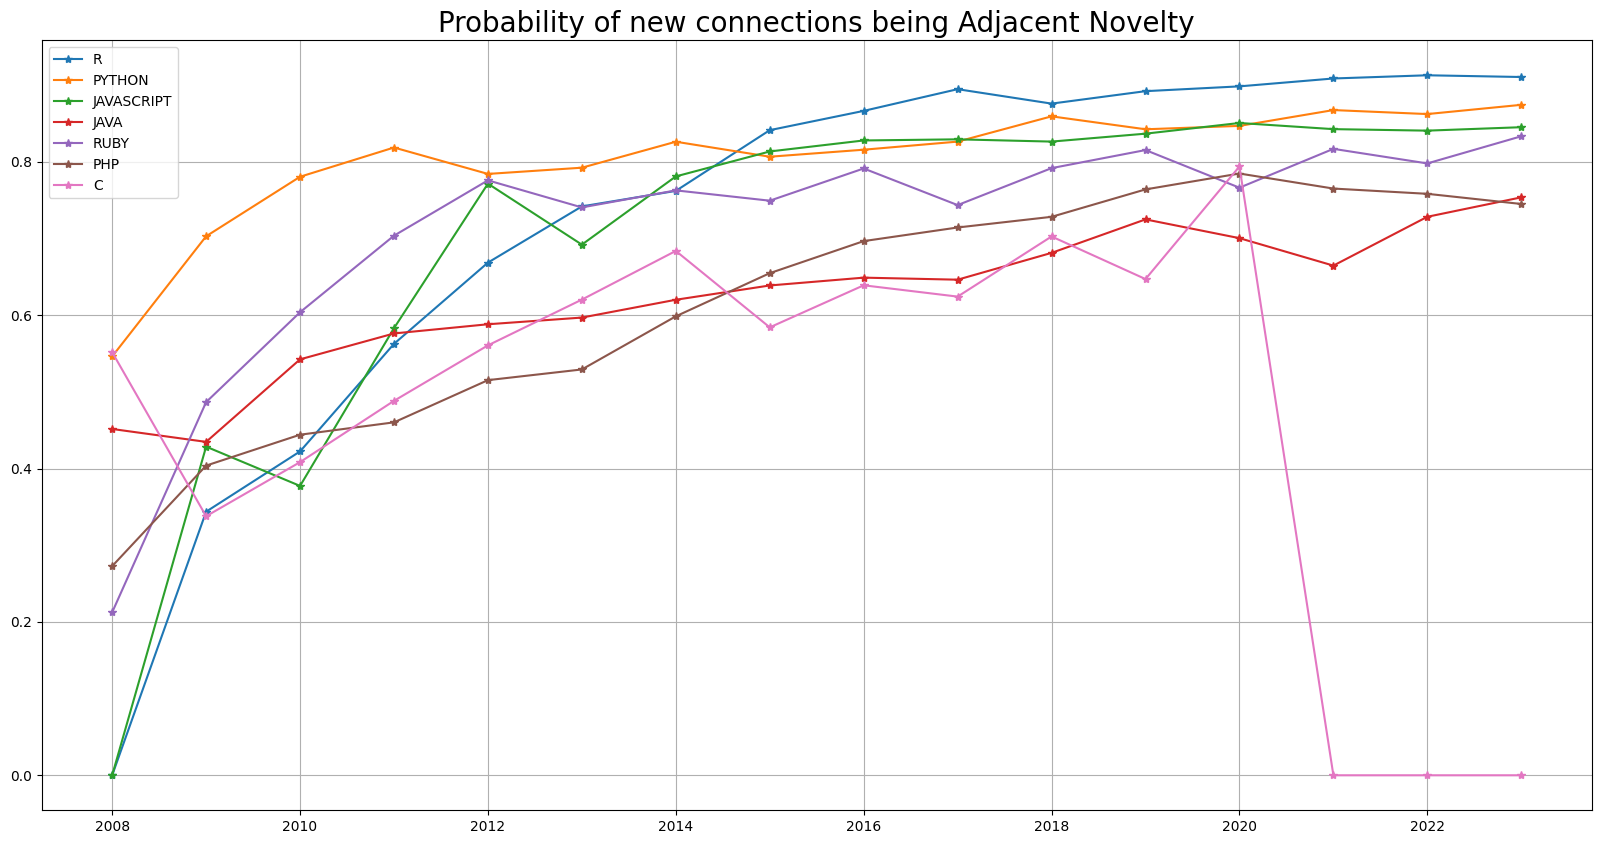

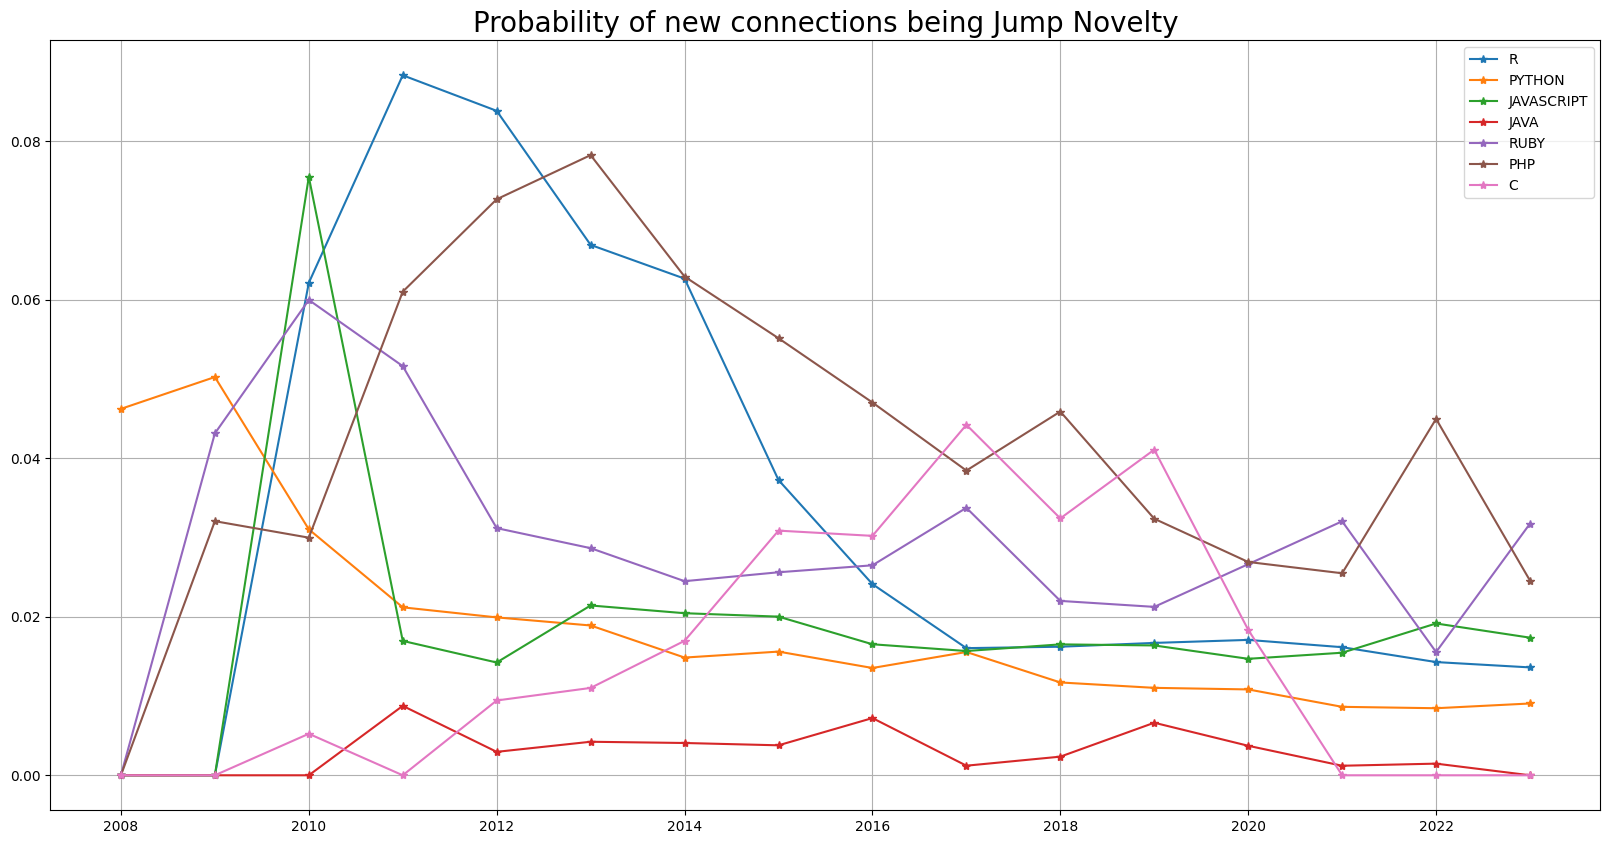

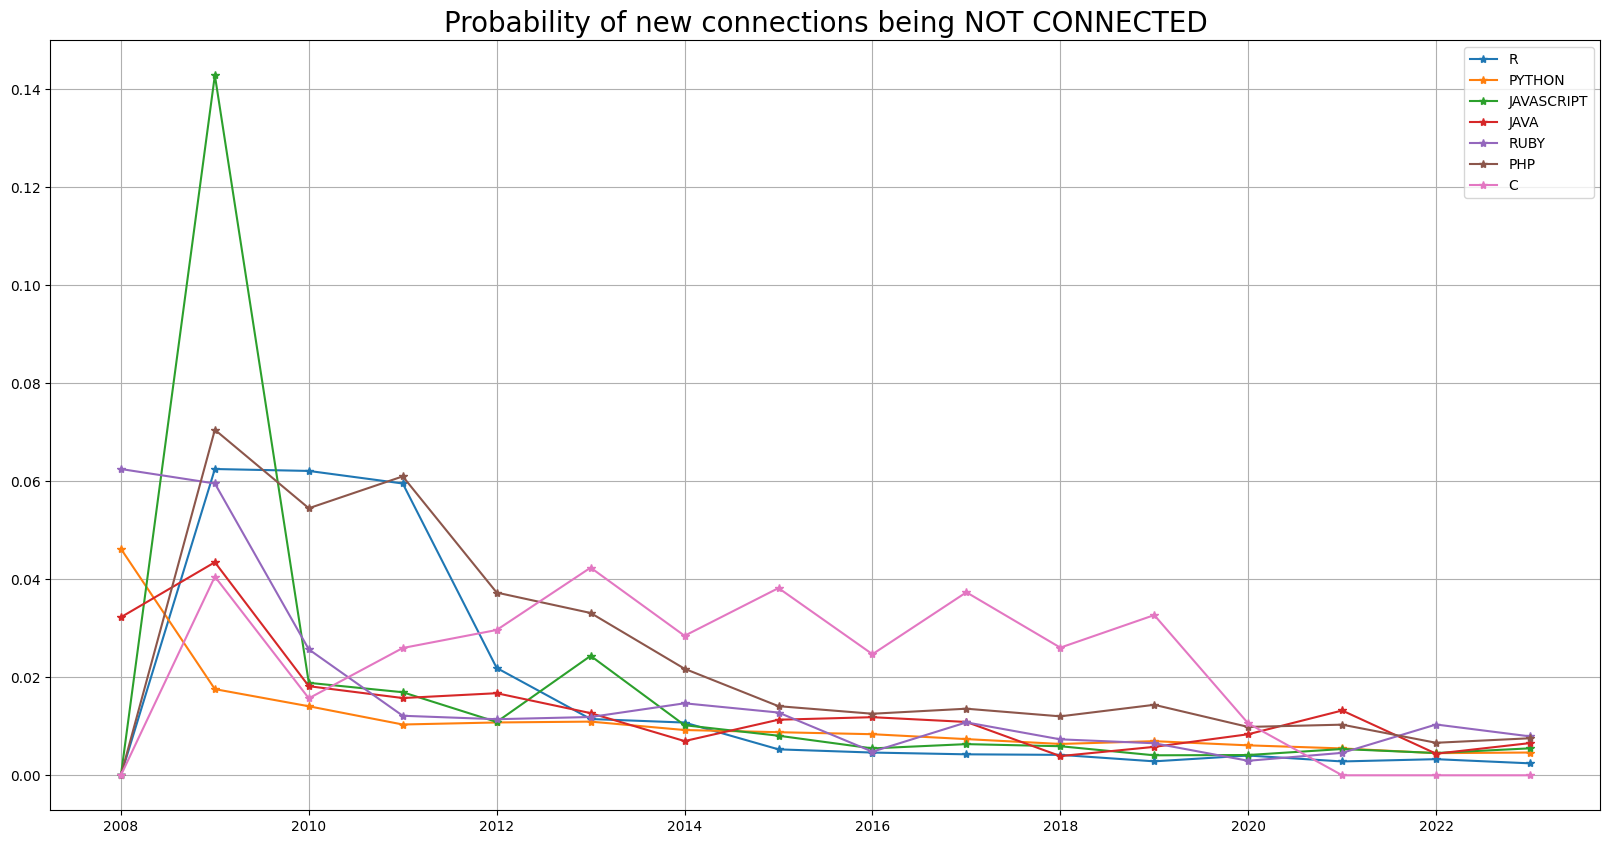

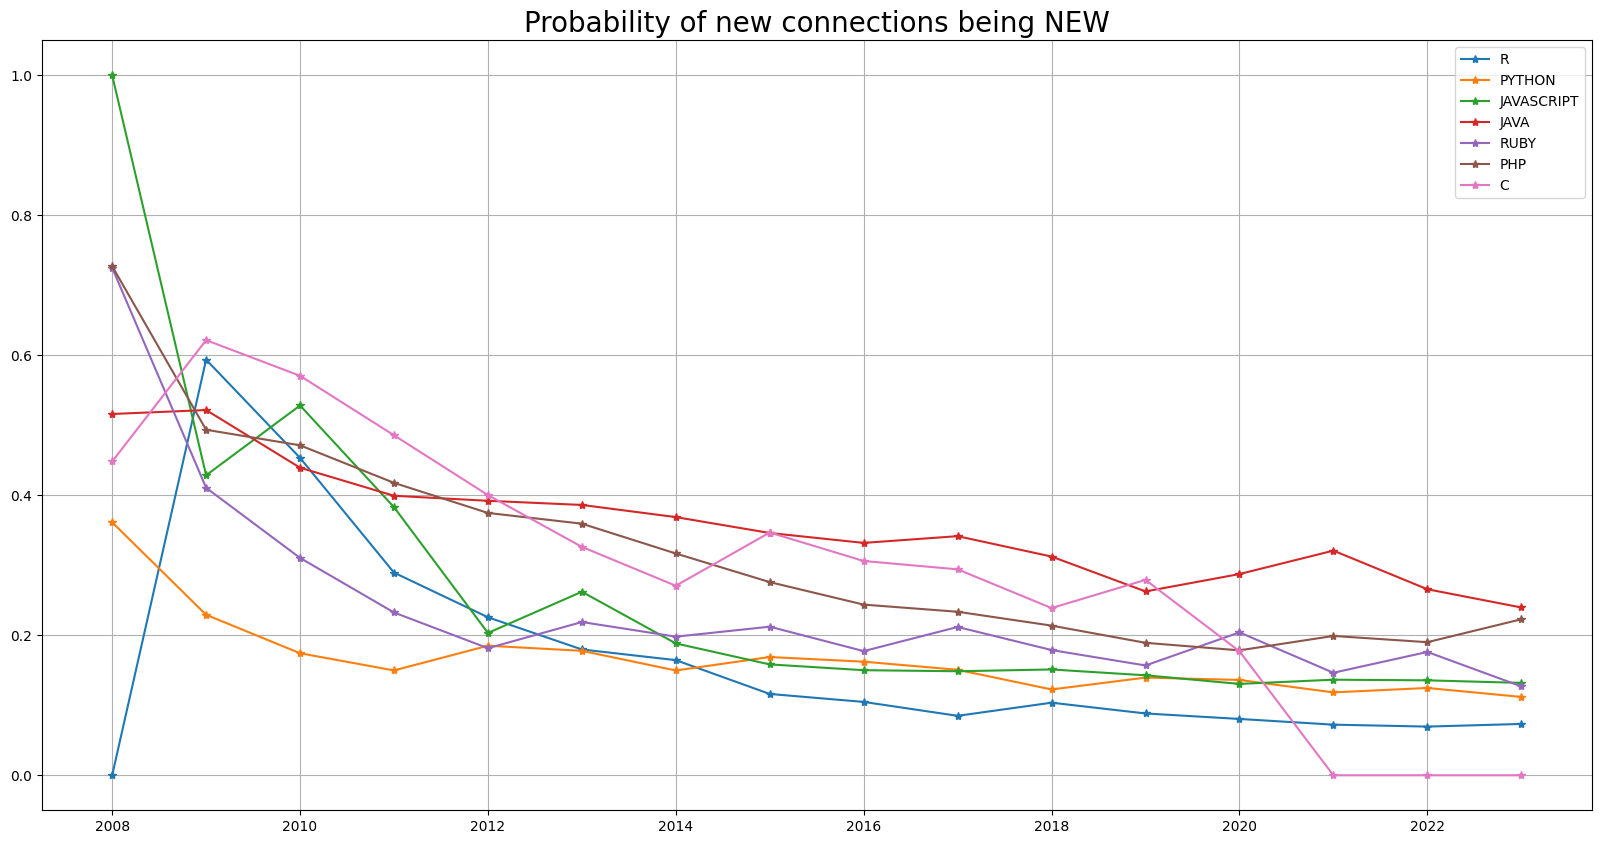

In [29]:
for key, target in {'Adjacent Novelty': 'inner', 'Jump Novelty': 'outer', 'NOT CONNECTED': 'inf', "NEW": "newby"}.items():
    plt.figure(figsize=(20, 10))
    title = f"Probability of new connections being {key}" 
    plt.title(title, fontsize=20)
    plt.grid()

    for language in list(set(LANGUAGES) - set(['rust'])):
        ad = annual_distributions[language]
        plt.plot(
            ad.keys(),
            [ad[x][target] /max(1, (ad[x]["inner"] + ad[x]["outer"] + ad[x]["inf"] + ad[x]["newby"])) for x in ad.keys()],
            "*-",
            label=f"{language.upper()}",
        )
        #inners = [ad[x]["inner"] /max(1, (ad[x]["inner"] + ad[x]["outer"] + ad[x]["inf"])) for x in xs]
        #outers= [ad[x]["outer"] /max(1, (ad[x]["inner"] + ad[x]["outer"] + ad[x]["inf"])) for x in xs]
        #infs = [ad[x]["inf"] /max(1, (ad[x]["inner"] + ad[x]["outer"] + ad[x]["inf"])) for x in xs]
        #plt.plot(xs, inners, label=f"{language.upper()} - Inner connections")
        # plt.plot(xs, outers, "*-", label=f"{language.upper()} - Outer connections")
        #plt.plot(xs, infs, "*-", label=f"{language.upper()} - No connections")

    plt.legend()
    plt.savefig(f"{title}.png")
    

# Repeat for Valuable only

In [36]:
annual_distributions_v = {
    language: {year: {"inner": 0, "outer": 0, "newby": 0, "inf": 0}for year in range(2008, 2024)} for language in LANGUAGES
}
total_datapoints = {language: 0 for language in LANGUAGES}

for language in LANGUAGES:
    print(f">>{language}<<")
    valuable_pairs = get_valuable_pairs(language, 365, 5)    
    
    with open(f"data/results/{language}/{language}_pairs_first_dates.json") as handle:
        pairs_first_dates = json.load(handle)
    with open(f"data/results/{language}/{language}_distance_at_connection.json") as handle:
        distance_at_connection = json.load(handle)
    stats = collections.defaultdict(int)
    for pair_name, data in tqdm.tqdm(pairs_first_dates.items()):
        if pair_name not in distance_at_connection:
            stats["pair not in distance"] += 1
            continue
        if pair_name not in valuable_pairs:
            stats["pair not valuable"] += 1
            continue
        node_a, node_b = pair_name.split("|")
        
        year = int(data.get("date")[:4])
        dist = distance_at_connection[pair_name]
        stats['success'] += 1
        total_datapoints[language] += 1
        match dist:
            case np.infty:
                annual_distributions_v[language][year]["inf"] += 1
            case -1:
                annual_distributions_v[language][year]["newby"] += 1
            case 2:
                annual_distributions_v[language][year]["inner"] += 1
            case _:
                annual_distributions_v[language][year]["outer"] += 1
    print(stats)

>>rust<<


100%|███████████████████████████████████████| 10/10 [00:00<00:00, 129854.61it/s]

defaultdict(<class 'int'>, {'pair not valuable': 10})
>>python<<



100%|██████████████████████████████| 371121/371121 [00:00<00:00, 1357410.58it/s]


defaultdict(<class 'int'>, {'pair not valuable': 365145, 'success': 5963, 'pair not in distance': 13})
>>javascript<<


100%|██████████████████████████████| 110147/110147 [00:00<00:00, 1333227.53it/s]


defaultdict(<class 'int'>, {'success': 3523, 'pair not valuable': 106617, 'pair not in distance': 7})
>>java<<


100%|████████████████████████████████| 16327/16327 [00:00<00:00, 1194557.56it/s]


defaultdict(<class 'int'>, {'success': 200, 'pair not valuable': 16127})
>>ruby<<


100%|████████████████████████████████| 15229/15229 [00:00<00:00, 1750912.96it/s]


defaultdict(<class 'int'>, {'pair not valuable': 14938, 'success': 291})
>>r<<


100%|████████████████████████████████| 79548/79548 [00:00<00:00, 1367030.89it/s]


defaultdict(<class 'int'>, {'pair not valuable': 77360, 'success': 2184, 'pair not in distance': 4})
>>c<<


100%|████████████████████████████████| 12788/12788 [00:00<00:00, 1512300.44it/s]


defaultdict(<class 'int'>, {'pair not valuable': 12547, 'pair not in distance': 222, 'success': 19})
>>php<<


100%|████████████████████████████████| 25513/25513 [00:00<00:00, 1615648.97it/s]

defaultdict(<class 'int'>, {'pair not valuable': 25085, 'success': 428})


In [37]:
total_datapoints

{'rust': 0,
 'python': 5963,
 'javascript': 3523,
 'java': 200,
 'ruby': 291,
 'r': 2184,
 'c': 19,
 'php': 428}

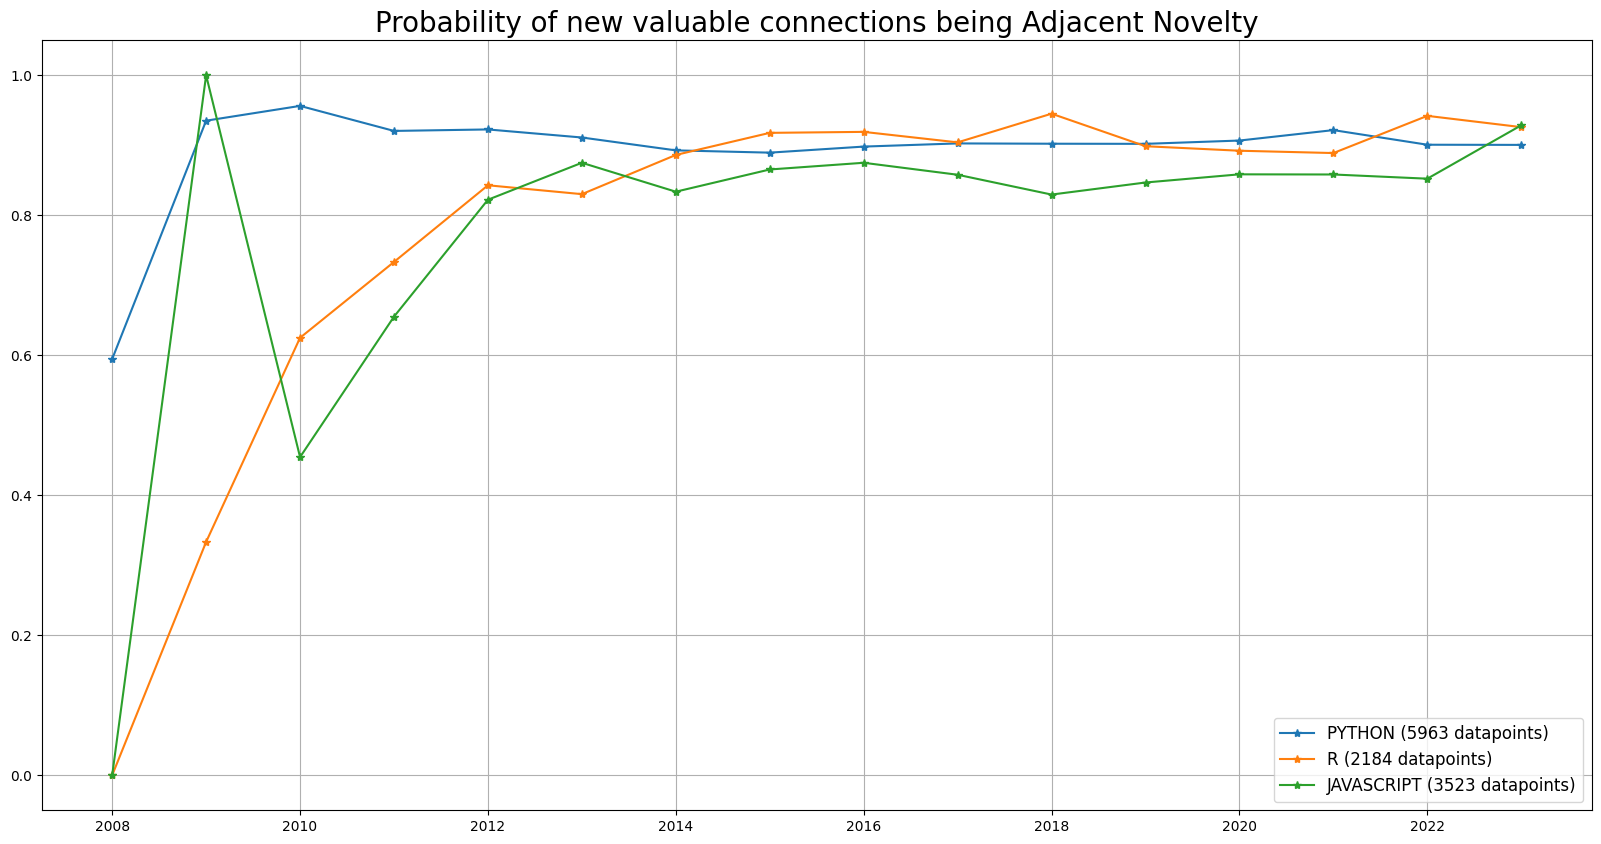

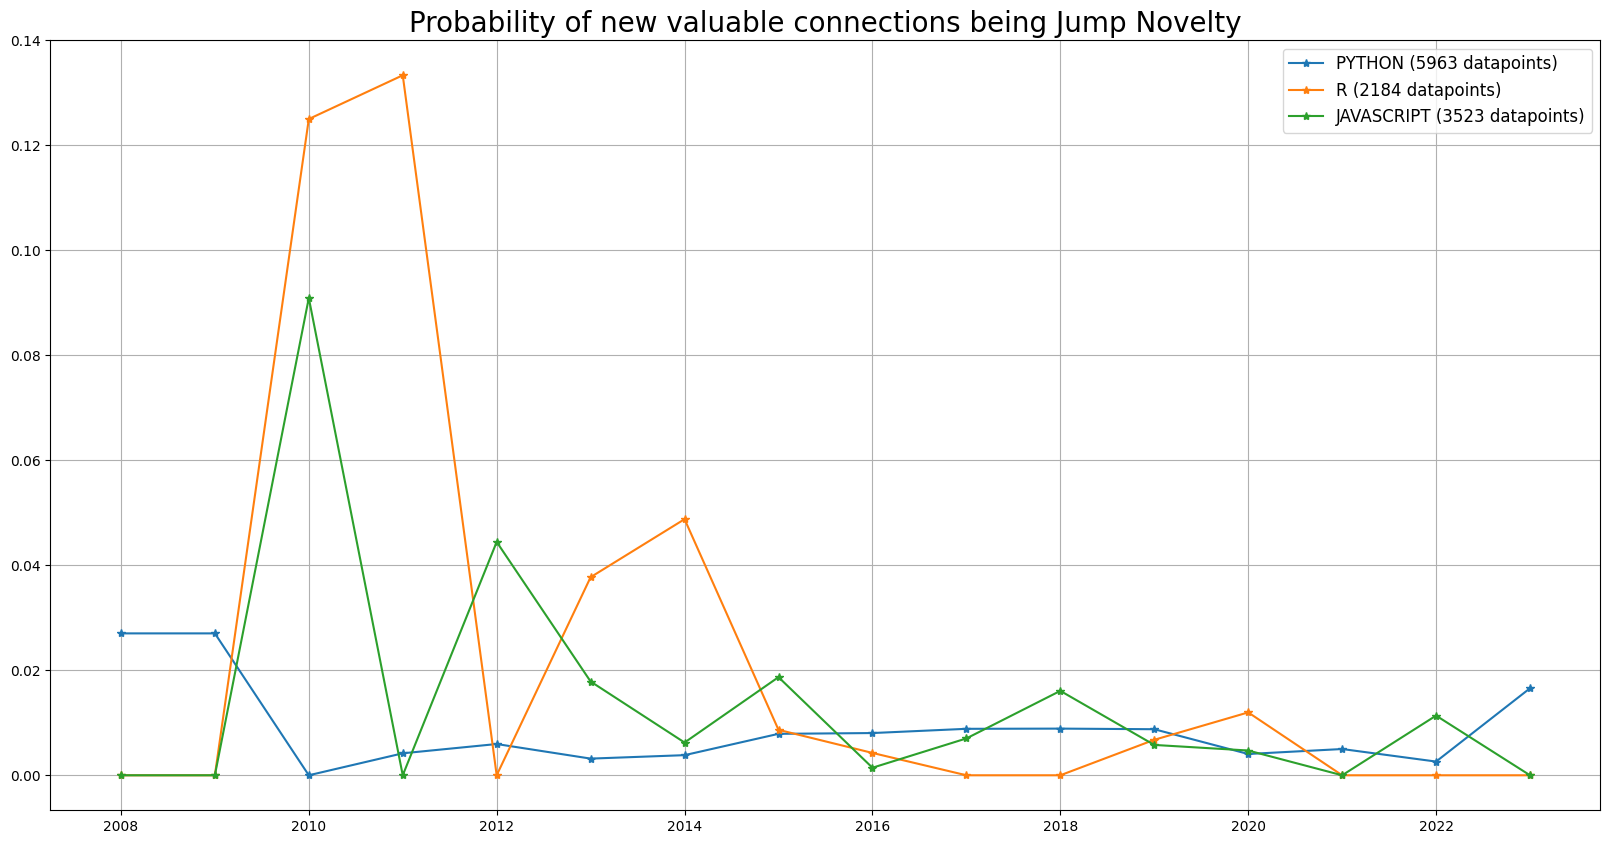

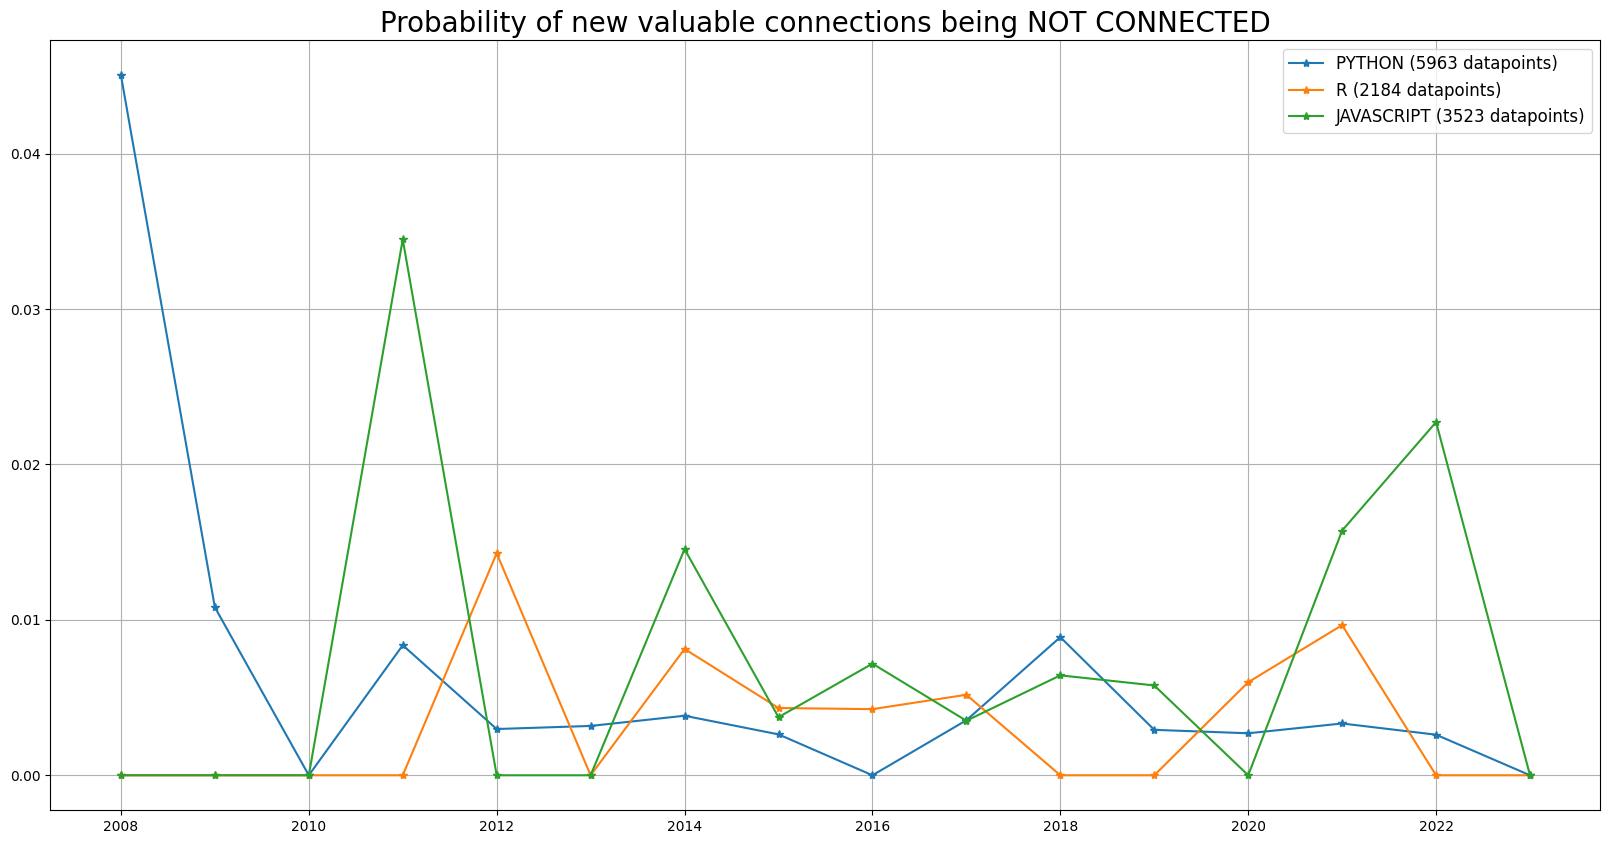

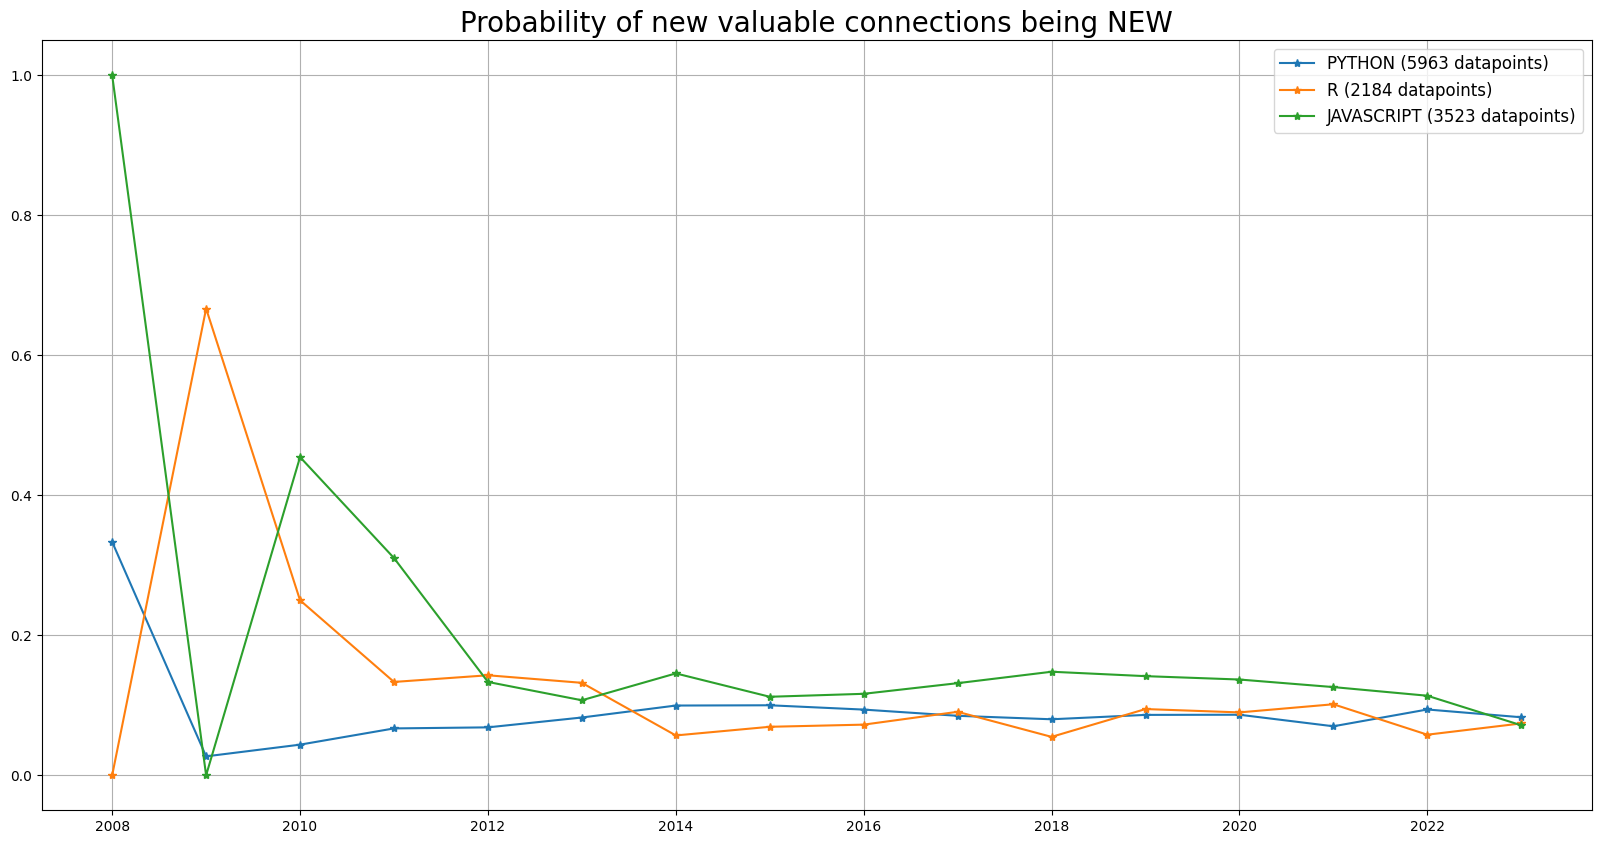

In [39]:
LANGUAGES = [
    #"rust",
    "python",
    "javascript",
    #"java",
    #"ruby",
    "r",
    #"c",
    #"php",
]


for key, target in {'Adjacent Novelty': 'inner', 'Jump Novelty': 'outer', 'NOT CONNECTED': 'inf', "NEW": "newby"}.items():
    plt.figure(figsize=(20, 10))
    title = f"Probability of new valuable connections being {key}" 
    plt.title(title, fontsize=20)
    plt.grid()

    for language in list(set(LANGUAGES) - set(['rust'])):
        ad = annual_distributions_v[language]
        plt.plot(
            ad.keys(),
            [ad[x][target] /max(1, (ad[x]["inner"] + ad[x]["outer"] + ad[x]["inf"] + ad[x]["newby"])) for x in ad.keys()],
            "*-",
            label=f'{language.upper()} ({total_datapoints[language]} datapoints)',
        )
        #inners = [ad[x]["inner"] /max(1, (ad[x]["inner"] + ad[x]["outer"] + ad[x]["inf"])) for x in xs]
        #outers= [ad[x]["outer"] /max(1, (ad[x]["inner"] + ad[x]["outer"] + ad[x]["inf"])) for x in xs]
        #infs = [ad[x]["inf"] /max(1, (ad[x]["inner"] + ad[x]["outer"] + ad[x]["inf"])) for x in xs]
        #plt.plot(xs, inners, label=f"{language.upper()} - Inner connections")
        # plt.plot(xs, outers, "*-", label=f"{language.upper()} - Outer connections")
        #plt.plot(xs, infs, "*-", label=f"{language.upper()} - No connections")

    plt.legend(fontsize=12)
    plt.savefig(f"{title}.png")
    